In [35]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/MSAI349/349_project/lstm_data.csv"
# file_path = "/content/drive/MyDrive/NORTHWESTERN/Frosh Fall/MSAI 349/349_project/pass_run_pbp_2019_norm.csv"
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df.head()

,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,quarter_seconds_remaining,half_seconds_remaining,...,home_timeouts_remaining,away_timeouts_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,play_type
0,0.0,0.0,0.741935,0.741935,1.0,0.000000,0.46,0.755102,1.000000,1.000000,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,0
1,0.0,0.0,0.741935,0.741935,1.0,0.000000,0.46,0.755102,0.970000,0.985000,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,1
2,0.0,0.0,0.741935,0.741935,1.0,0.000000,0.46,0.755102,0.916667,0.958333,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,1
3,0.0,0.0,0.741935,0.000000,0.0,0.741935,0.00,0.520408,0.836667,0.918333,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,0
4,0.0,0.0,0.741935,0.000000,0.0,0.741935,0.46,0.469388,0.797778,0.898889,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,1


In [4]:
df.columns

Index(['game_id', 'home_team', 'away_team', 'posteam', 'posteam_type',
       'defteam', 'side_of_field', 'yardline_100', 'quarter_seconds_remaining',
       'half_seconds_remaining', 'game_seconds_remaining', 'game_half',
       'drive', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'ydsnet', 'no_huddle',
       'home_timeouts_remaining', 'away_timeouts_remaining',
       'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'total_home_score', 'total_away_score', 'posteam_score',
       'defteam_score', 'score_differential', 'play_type'],
      dtype='object')

In [5]:
# # take out non-numerical columns for LSTM
# df = df['play_id', 'game_id', 'home_team', 'away_team', 'posteam',
#        'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date',
#        'quarter_seconds_remaining', 'half_seconds_remaining',
#        'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down',
#        'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'play_type',
#        'no_huddle', 'home_timeouts_remaining', 'away_timeouts_remaining',
#        'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
#        'total_home_score', 'total_away_score', 'posteam_score',
#        'defteam_score', 'score_differential']

In [6]:
# sorted_df = df.sort_values(by=['game_id', 'play_id'])

In [7]:
# make posteam and defteam columns binary
# df['home_team_pos'] = (sorted_df['posteam'] == sorted_df['home_team']).astype(int)
# sorted_df['away_team_pos'] = (sorted_df['posteam'] == sorted_df['away_team']).astype(int)

In [8]:
# take out 'play_id', 'game_id', 'home_team', 'away_team', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'game_date', 'game_half'

In [9]:
# Group by 'group_column'
grouped = df.groupby('game_id')

# Create a dictionary to store each group as a DataFrame
group_dfs = {name: group for name, group in grouped}

group_dfs.keys()

dict_keys([0.0, 0.0092549745459109, 0.0092858244606759, 0.0093166743754409, 0.0093475242902059, 0.0093783742049708, 0.0094092241197358, 0.0094400740417768, 0.0094709239565418, 0.0095017738713067, 0.0095326237860717, 0.0095634737008367, 0.0095943236156017, 0.0096251735303667, 0.0123399660660652, 0.0123708159808302, 0.0215949406119762, 0.0308499151578871, 0.030880765079928, 0.030911614994693, 0.030942464909458, 0.030973314824223, 0.031004164738988, 0.031035014653753, 0.031065864568518, 0.0310967144832829, 0.0311275643980479, 0.0311584143128129, 0.0311892642275779, 0.0312201141423429, 0.0312509640571079, 0.0339349066780414, 0.0431898812239524, 0.0524448557771393, 0.0524757056919042, 0.0525065556066692, 0.0525374055214342, 0.0525682554361992, 0.0525991053509642, 0.0526299552657292, 0.0526608051804942, 0.0526916550952591, 0.0527225050100241, 0.0527533549247891, 0.0527842048395541, 0.0528150547543191, 0.0528459046690841, 0.0555298472900176, 0.0647848218432045, 0.0740397963891155, 0.074070646

In [10]:
# Assuming group_dfs is your dictionary of grouped DataFrames
group_sizes = {group_name: len(group_df) for group_name, group_df in group_dfs.items()}

# Find the group with the minimum size
min_group_name = min(group_sizes, key=group_sizes.get)
min_group_size = group_sizes[min_group_name]

print(f"The smallest group is '{min_group_name}' with {min_group_size} rows.")

The smallest group is '0.3549899737772648' with 103 rows.


In [11]:
# Iterate over each group in the dictionary and take the first 100 rows
first_100_rows_group_dfs = {group_name: group_df.head(100) for group_name, group_df in group_dfs.items()}

In [12]:
# Assuming first_100_rows_group_dfs is your dictionary
for group_name, group_df in first_100_rows_group_dfs.items():
    # Reset the index, add 1 to make it start from 1, then assign it as a new column
    group_df.reset_index(drop=True, inplace=True)
    group_df['step'] = group_df.index + 1

<ipython-input-12-22f8c49edfeb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df['step'] = group_df.index + 1
<ipython-input-12-22f8c49edfeb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_df['step'] = group_df.index + 1
<ipython-input-12-22f8c49edfeb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [13]:
first_100_rows_group_dfs[0.0].columns

Index(['game_id', 'home_team', 'away_team', 'posteam', 'posteam_type',
       'defteam', 'side_of_field', 'yardline_100', 'quarter_seconds_remaining',
       'half_seconds_remaining', 'game_seconds_remaining', 'game_half',
       'drive', 'qtr', 'down', 'goal_to_go', 'ydstogo', 'ydsnet', 'no_huddle',
       'home_timeouts_remaining', 'away_timeouts_remaining',
       'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'total_home_score', 'total_away_score', 'posteam_score',
       'defteam_score', 'score_differential', 'play_type', 'step'],
      dtype='object')

In [14]:
columns_to_drop = ['play_id', 'game_id', 'home_team', 'away_team', 'posteam', 'posteam_type', 'defteam', 'side_of_field', 'game_date', 'game_half', 'time',
       'yrdln', 'step']

# Iterate over each group in the dictionary and drop the specified columns
for group_name, group_df in first_100_rows_group_dfs.items():
    first_100_rows_group_dfs[group_name] = group_df.drop(columns=columns_to_drop, errors='ignore')


In [15]:
first_100_rows_group_dfs[0.0].columns

Index(['yardline_100', 'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'drive', 'qtr', 'down', 'goal_to_go',
       'ydstogo', 'ydsnet', 'no_huddle', 'home_timeouts_remaining',
       'away_timeouts_remaining', 'posteam_timeouts_remaining',
       'defteam_timeouts_remaining', 'total_home_score', 'total_away_score',
       'posteam_score', 'defteam_score', 'score_differential', 'play_type'],
      dtype='object')

In [16]:
first_100_rows_group_dfs[0.0].dtypes

yardline_100                  float64
quarter_seconds_remaining     float64
half_seconds_remaining        float64
game_seconds_remaining        float64
drive                         float64
qtr                           float64
down                          float64
goal_to_go                    float64
ydstogo                       float64
ydsnet                        float64
no_huddle                     float64
home_timeouts_remaining       float64
away_timeouts_remaining       float64
posteam_timeouts_remaining    float64
defteam_timeouts_remaining    float64
total_home_score              float64
total_away_score              float64
posteam_score                 float64
defteam_score                 float64
score_differential            float64
play_type                       int64
dtype: object

In [17]:
# for group_name, group_df in group_dfs.items():
#     scaler = StandardScaler()
#     columns_to_scale = [col for col in group_df.columns if col not in ['step', 'play_type'] and group_df[col].dtype == np.number]

#     scaled_data = scaler.fit_transform(group_df[columns_to_scale])

#     group_dfs[group_name][columns_to_scale] = scaled_data

In [18]:
first_100_rows_group_dfs[0.0].head()

,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,drive,qtr,down,goal_to_go,ydstogo,ydsnet,...,home_timeouts_remaining,away_timeouts_remaining,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,play_type
0,0.755102,1.000000,1.000000,1.000000,0.000000,0.0,0.000000,0.0,0.230769,0.099174,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,0
1,0.755102,0.970000,0.985000,0.992500,0.000000,0.0,0.333333,0.0,0.230769,0.099174,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,1
2,0.755102,0.916667,0.958333,0.979167,0.000000,0.0,0.666667,0.0,0.230769,0.099174,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,1
3,0.520408,0.836667,0.918333,0.959167,0.032258,0.0,0.000000,0.0,0.230769,0.280992,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,0
4,0.469388,0.797778,0.898889,0.949444,0.032258,0.0,0.333333,0.0,0.102564,0.280992,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.5,1


In [19]:
len(first_100_rows_group_dfs)

256

In [20]:
# Empty lists to hold features and labels
features_list = []
labels_list = []

for group_name, group_df in first_100_rows_group_dfs.items():
    # Assuming 'step' is the index and 'play_type' is the label
    features = group_df.drop(columns=['play_type']).values  # Extract features
    labels = group_df['play_type'].values  # Extract labels

    # Convert to PyTorch tensors and add to lists
    features_tensor = torch.tensor(features, dtype=torch.float32)
    labels_tensor = torch.tensor(labels, dtype=torch.float32)

    features_list.append(features_tensor)
    labels_tensor = labels_tensor.unsqueeze(1)  # Reshape for binary classification
    labels_list.append(labels_tensor)


In [21]:
features_tensor = torch.stack(features_list)
labels_tensor = torch.stack(labels_list)

In [22]:
labels_tensor.size()

torch.Size([256, 100, 1])

LSTM model

In [23]:
import torch
import torch.nn as nn

import torch
import torch.nn as nn

"""
Dimensions for input data
1: game (256)
2: plays (100)
3: features (20)
"""


# lstm = nn.LSTM(3, 3)
# inputs = [torch.randn(1, 3) for _ in range(5)] # Change to input data, list of tensors of size [1, 3]

# hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))
# for i in inputs:
#   out, hidden = lstm(i.view(1, 1, -1), hidden)
#   print(hidden)
# print(out)


'\nDimensions for input data\n1: game (256)\n2: plays (100)\n3: features (20)\n'

In [24]:
# data
sequence_length = 100
num_features = 20
num_samples = 256

# X = torch.randn(num_samples, sequence_length, num_features)  # Random data
# y = torch.randint(0, 2, (num_samples, sequence_length, 1)).float()  # Random binary labels
X = features_tensor
y = labels_tensor
print(X.size())
print(y.size())


# Create DataLoader for batch processing
dataset = TensorDataset(X, y)
# dataset = TensorDataset(features_list, labels_list)
train_loader = DataLoader(dataset, batch_size=100, shuffle=True)


torch.Size([256, 100, 20])
torch.Size([256, 100, 1])


In [25]:
# get train test splits
total_samples = len(X)
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [26]:
# create train test dataloaders
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [27]:
# class LSTMClassifier(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim=1):
#         super(LSTMClassifier, self).__init__()
#         self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
#         self.fc = nn.Linear(hidden_dim, output_dim)

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         lstm_out = lstm_out[:, -1, :]  # Take the output of the last time step
#         y_pred = torch.sigmoid(self.fc(lstm_out))
#         return y_pred

# # Initialize the model
# model = LSTMClassifier(num_features, 50)  # 50 is the hidden dimension


In [28]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LSTMSeq2Seq, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # Shape of lstm_out: [batch, sequence_length, hidden_dim]
        y_pred = torch.sigmoid(self.fc(lstm_out))  # Shape of y_pred: [batch, sequence_length, output_dim]
        return y_pred

# Initialize the model
model = LSTMSeq2Seq(num_features, hidden_dim=50)  # Choose a suitable hidden_dim


In [29]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [30]:
num_epochs = 1000

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}")


Epoch 1/1000, Loss: 0.6995488405227661
Epoch 11/1000, Loss: 0.690776526927948
Epoch 21/1000, Loss: 0.6856636802355448
Epoch 31/1000, Loss: 0.686090886592865
Epoch 41/1000, Loss: 0.6744853854179382
Epoch 51/1000, Loss: 0.6811282634735107
Epoch 61/1000, Loss: 0.6747244795163473
Epoch 71/1000, Loss: 0.6716553370157877
Epoch 81/1000, Loss: 0.6738561789194742
Epoch 91/1000, Loss: 0.6758590340614319
Epoch 101/1000, Loss: 0.6745813290278116
Epoch 111/1000, Loss: 0.674523115158081
Epoch 121/1000, Loss: 0.6709247430165609
Epoch 131/1000, Loss: 0.6726605494817098
Epoch 141/1000, Loss: 0.6781352162361145
Epoch 151/1000, Loss: 0.6713828841845194
Epoch 161/1000, Loss: 0.66867729028066
Epoch 171/1000, Loss: 0.6712019244829813
Epoch 181/1000, Loss: 0.669402003288269
Epoch 191/1000, Loss: 0.6646132469177246
Epoch 201/1000, Loss: 0.6689130862553915
Epoch 211/1000, Loss: 0.6632651885350546
Epoch 221/1000, Loss: 0.6634136438369751
Epoch 231/1000, Loss: 0.6618161797523499
Epoch 241/1000, Loss: 0.664119084

In [40]:
# Assuming you have a test_loader
model.eval()
with torch.no_grad():
    correct = 0
    total=0
    i = 0
    for X_batch, y_batch in test_loader:
        print(i)
        i += 1
        y_pred = model(X_batch)
        predicted = (y_pred > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0) * y_batch.size(1)
        print(y_pred.size)
        print(predicted.size)

print(f'Accuracy: {100 * correct / total}%')


0
<built-in method size of Tensor object at 0x7bcc1b574130>
<built-in method size of Tensor object at 0x7bcc32985bc0>
Accuracy: 64.73076923076923%


In [47]:
predicted = predicted.reshape(-1)
y_batch = y_batch.reshape(-1)

tensor([1., 0., 0.,  ..., 0., 1., 0.])

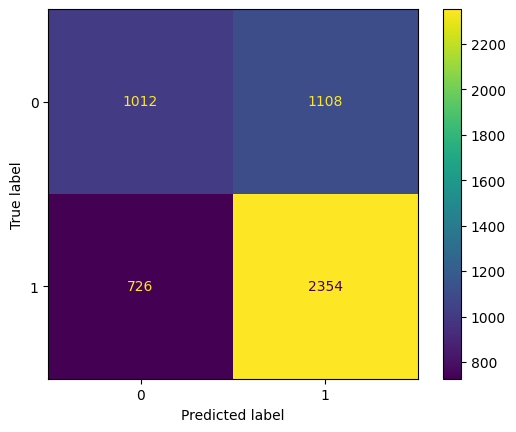

In [49]:
cm = confusion_matrix(y_batch, predicted, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [51]:
precision = 2354 / (2354 + 1108)
recall = 2354 / (2354 + 726)
f1_score = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1_score)

0.6799537839399191 0.7642857142857142 0.7196575970651177
